# Classification

Dans cette partie, on va classifier les utilisateurs ayant une session selon qu'ils aient réservé ou non. On va donc garder l'étiquette **NDF** et le reste des étiquettes de la colonne **country_destination** sera marqué comme **DF**.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tools.metrics import confusion_matrix, cross_validation_score
plt.style.use('seaborn')

## Features engineering


In [24]:
# Import data
users = pd.read_csv('data/train_users_2.csv')
test_users = pd.read_csv('data/test_users.csv')
sessions = pd.read_csv('data/sessions.csv')

# Add labels DF/NDF
users['destination_found'] = users.apply(lambda r: 'NDF' if r['country_destination'] == 'NDF' else 'DF', axis=1)

# Retain users that have a session & add information about their session
sessions_naless = sessions.fillna('_')
sessions['action_name'] = sessions_naless['action'] + '-' + sessions_naless['action_type'] + '-' + sessions_naless['action_detail']
users_sessions = sessions.groupby('user_id').agg({
    "action_name": pd.Series.tolist,
    'secs_elapsed': lambda r: round(r.sum() / (60**2), 0),
})
users_sessions = users_sessions.rename({"secs_elapsed":"hours_elapsed", "action_name":"actions",}, axis=1)
users = users_sessions.reset_index().rename({'user_id':'id'}, axis=1).merge(users, how='inner', on='id')
users = users.sort_values('id')

In [25]:
print("users.head : ", users.shape)
users.tail(3)

users.head :  (73815, 19)


,id,actions,hours_elapsed,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,destination_found
73812,zzysuoqg6x,"[hosting_social_proof--unknown---unknown-, cre...",0.0,2014-01-08,20140108221010,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Windows Desktop,IE,NDF,NDF
73813,zzywmcn0jv,"[header_userpic-data-header_userpic, personali...",597.0,2014-02-21,20140221160109,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,iPhone,Mobile Safari,NDF,NDF
73814,zzzlylp57e,"[similar_listings-data-similar_listings, show-...",120.0,2014-06-11,20140611074639,2014-06-24,-unknown-,NaN,basic,0,en,seo,google,linked,Web,Windows Desktop,Chrome,FR,DF


In [26]:
# Converting date string into datetime object
users['timestamp_first_active'] = pd.to_datetime(users['timestamp_first_active'], format='%Y%m%d%H%M%S')
users['date_account_created'] = pd.to_datetime(users['date_account_created'], format='%Y-%m-%d')
users["date_first_booking"] = pd.to_datetime(users['date_first_booking'], format='%Y-%m-%d')
users['date_first_active'] = pd.to_datetime(users['timestamp_first_active'].dt.date, format='%Y-%m-%d')
users['hour_first_active'] = users['timestamp_first_active'].dt.hour
users['month_first_active'] = users['date_first_active'].dt.month
users['year_first_active'] = users['date_first_active'].dt.year

In [27]:
def process_age(age):
    if age > 1000:
        return 2015 - age
    elif age == 105:
        return -2
    elif age < 100:
        return age
    else: 
        return -1

# Bucketize age variable
users['age'] = users.apply(lambda r: process_age(r['age']), axis=1)
users['age_group'] = sum([(users['age'] < 0).astype(int),
    (users['age'] < 18).astype(int),
    (users['age'] < 25).astype(int),
    (users['age'] < 30).astype(int),
    (users['age'] < 35).astype(int),
    (users['age'] < 40).astype(int),
    (users['age'] < 60).astype(int),
    (users['age'] < 100).astype(int)])

In [28]:
def process_signup_flow(num_page):
    if num_page <= 3:
        return num_page
    elif 3 < num_page < 12:
        return 'middle'
    else:
        return 12
    
# Bucketize signup_flow
users['signup_flow_group'] = users.apply(lambda r: process_signup_flow(r['signup_flow']), axis=1)

In [29]:
# Bucketize language
users['language_group'] = (users['language'] == 'en').astype(int)

In [30]:
# Only retains browser which have a large enough set of users
users_browsers = users.groupby('first_browser').count()[['id']].sort_values(by='id')
browsers = set(users_browsers[users_browsers['id'] > 1000].index)
users['first_browser_processed'] = users.apply(lambda r: r['first_browser'] if r['first_browser'] in browsers else 'Other', axis=1)

In [31]:
# Fill Nan in first_affiliate_tracked
users['first_affiliate_tracked'] = users['first_affiliate_tracked'].fillna('-unknown-')

In [32]:
# Most use device type (phone or pc)
devices = sessions.groupby('user_id').agg({'device_type': lambda r: r.values.tolist(),}).reset_index().rename({'user_id':'id'}, axis=1)
devices['most_use'] = devices.apply(lambda r: max(set(r['device_type']), key=r['device_type'].count), axis=1)

phones = ['iPhone', 'iPad Tablet', 'Android App Unknown Phone/Tablet', 'Android Phone', 'Tablet', 'Chromebook', 'Blackberry',
          'Windows Phone', 'Opera Phone', 'iPodtouch']
pcs = ['Mac Desktop', 'Windows Desktop', 'Linux Desktop']

def most_use2group(most_use):
    exp = most_use.split('_count')[0]  # Remove _count suffix
    if exp in phones:
        return 'phone'
    elif exp in pcs:
        return 'pc'
    else:
        return '-unknown-'
    
devices['most_use_device_group'] = devices.apply(lambda r: most_use2group(r['most_use']), axis=1)
devices.drop('most_use', axis=1)
users = users.merge(devices, on='id', how='inner')

In [33]:
# Bucketize number of hours elasped
users['hours_elapsed_group'] = sum([(users['hours_elapsed'] < 0).astype(int),
    (users['hours_elapsed'] < 50).astype(int),
    (users['hours_elapsed'] < 100).astype(int),
    (users['hours_elapsed'] < 150).astype(int),
    (users['hours_elapsed'] < 200).astype(int),
    (users['hours_elapsed'] < 250).astype(int),
    (users['hours_elapsed'] < 300).astype(int),])

In [34]:
# Bucketize number of unique actions
users['nb_unique_actions'] = users.apply(lambda r: len(set(r['actions'])), axis=1)
users['nb_unique_actions_group'] = sum([(users['nb_unique_actions'] < 14).astype(int),
    (users['nb_unique_actions'] < 16).astype(int),
    (users['nb_unique_actions'] < 18).astype(int),
    (users['nb_unique_actions'] < 20).astype(int),
    (users['nb_unique_actions'] < 22).astype(int),
    (users['nb_unique_actions'] < 24).astype(int),])

In [46]:
relevent_action_names = ['requested-submit-post_checkout_action',
 'requested-view-p5',
 'pending-booking_request-pending',
 'agree_terms_check--unknown---unknown-',
 'at_checkpoint-booking_request-at_checkpoint',
 'ajax_photo_widget_form_iframe--unknown---unknown-',
 'complete_status--unknown---unknown-',
 'complete_redirect--unknown---unknown-',
 'travel_plans_current-view-your_trips',
 'populate_from_facebook--unknown---unknown-',
 'social_connections-data-user_social_connections',
 'create-submit-signup',
 'update-submit-update_listing_description',
 'manage_listing-view-manage_listing',
 'set_user-submit-create_listing']


# Encode actions
one_hot_encoded_actions = pd.get_dummies(sessions[sessions['action_name'].isin(relevent_action_names)][['user_id', 'action_name']], columns=['action_name'])

# Generate functions for aggretation
columns = one_hot_encoded_actions.columns.values.tolist()
columns.remove('user_id')
agg_funcs = {col_name: sum for col_name in columns}

# Aggretate actions by users
actions_matrix = one_hot_encoded_actions.groupby('user_id').agg(agg_funcs)

# Selecting the most relevent columns
cols = ['action_name_' + name for name in relevent_action_names]
m = (actions_matrix[cols].div(actions_matrix[cols].sum(axis=1), axis=0).fillna(0) * 10)
m.head(3)

,action_name_requested-submit-post_checkout_action,action_name_requested-view-p5,action_name_pending-booking_request-pending,action_name_agree_terms_check--unknown---unknown-,action_name_at_checkpoint-booking_request-at_checkpoint,action_name_ajax_photo_widget_form_iframe--unknown---unknown-,action_name_complete_status--unknown---unknown-,action_name_complete_redirect--unknown---unknown-,action_name_travel_plans_current-view-your_trips,action_name_populate_from_facebook--unknown---unknown-,action_name_social_connections-data-user_social_connections,action_name_create-submit-signup,action_name_update-submit-update_listing_description,action_name_manage_listing-view-manage_listing,action_name_set_user-submit-create_listing
user_id,,,,,,,,,,,,,,,
00023iyk9l,0.0,6.25,1.25,0.0,0.000000,0.0,0.0,0.0,2.5,0.0,0.000000,0.000000,0.0,0.0,0.0
001wyh0pz8,0.0,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,6.666667,3.333333,0.0,0.0,0.0
002qnbzfs5,0.0,0.00,0.00,0.0,0.136986,0.0,0.0,0.0,0.0,0.0,9.863014,0.000000,0.0,0.0,0.0


In [36]:
action_names = ['ajax_refresh_subtotal-click-change_trip_characteristics', 
 'similar_listings-data-similar_listings', 'pending-booking_request-pending']

for name in action_names:
    users[f'did_{name}'] = users.apply(lambda r: 1 if name in r['actions'] else 0, axis=1)

In [47]:
users_final = users.merge(m.round(0).reset_index().rename({'user_id':'id'}, axis=1), how='left', on='id').fillna(0)

# Selecting features
features = ['month_first_active', 'gender', 'age_group', 'signup_method', 'signup_flow_group',  'affiliate_provider', 
           'signup_app', 'first_browser_processed',
           'hours_elapsed_group', 'nb_unique_actions_group', 'most_use_device_group']

features += ['action_name_' + name for name in relevent_action_names]
# features += [f"actions_embedding_{i}" for i in range(size)]
features += [f'did_{name}' for name in action_names]

data = users_final[features].copy()

# X = pd.get_dummies(data).values.astype(int)
X = pd.DataFrame()
for feature in features:
    X[feature] = data[feature].astype('category').cat.codes
X = X.values
y = users_final['destination_found'].values

In [48]:
print(data.shape, X.shape)

(73815, 29) (73815, 29)


## Training model

In [56]:
from sklearn.ensemble import RandomForestClassifier
from tools.metrics import f1_score, confusion_matrix
# from tools.forest import RandomForestClassifier
# from sklearn.metrics import f1_score, make_scorer

# Weights inverted for conter-balancing
nb_NDF = y.tolist().count('NDF')
nb_DF = y.tolist().count('DF')
class_weight = {'DF': 1-nb_DF/y.shape[0],
               'NDF': 1-nb_NDF/y.shape[0]}
model = RandomForestClassifier(n_estimators=50, max_depth=15, class_weight=class_weight)
# model = RandomForestClassifier(n_estimators=50, max_depth=15)
res = cross_validation_score(model, X, y, k=5, scorer=f1_score)
print(f"Mean score : {round(np.mean(res), 4)}")
print(f"Std score : {round(np.std(res), 5)}")

Mean score : 0.7105
Std score : 0.00473


0.7072415699281372

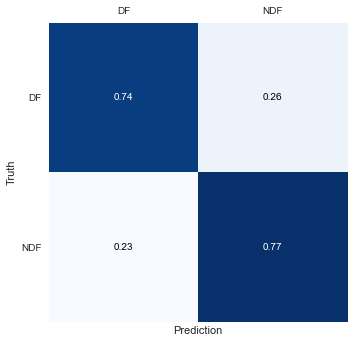

In [57]:
# Display confusion matrix
n = int(X.shape[0] * 0.7)
model.fit(X[:n], y[:n])
_ = confusion_matrix(model, X[n:], y[n:], plot=True, normalize=True)
f1_score(model.predict(X[n:]), y[n:])

## Training model on countries destination

In [58]:
pred = pd.DataFrame({
    'id': ['a', 'b', 'c'],
    'country_destination': [['FR', 'US'], ['NDF'], ['NDF', 'PT', 'FR', 'AU']],
    'true_destination': ['US', 'PT', 'FR'],
})

def dcg(destinations, truth):
    arr = (np.array(destinations) == truth).astype(int)
    return np.sum(((2 ** arr) - 1) / np.log2(np.arange(arr.shape[0]) + 2))

def ndcg(destinations, truth):
    t = destinations.count(truth)
    a = [truth if i < t else '-' for i in range(len(destinations))]
    max_dcg = dcg(a, truth)
    max_dcg = max_dcg + 1 if max_dcg == 0 else max_dcg
    return dcg(destinations, truth) / max_dcg

pred.apply(lambda r: ndcg(r['country_destination'], r['true_destination']), axis=1)

0    0.63093
1    0.00000
2    0.50000
dtype: float64

In [59]:
y = users_final['country_destination'].values
model = RandomForestClassifier(n_estimators=50, max_depth=15)
# model = RandomForestClassifier(n_estimators=50, max_depth=15)
res = cross_validation_score(model, X, y, k=5)
print(f"Mean score : {round(np.mean(res), 4)}")
print(f"Std score : {round(np.std(res), 5)}")

Mean score : 0.6968
Std score : 0.00188


In [60]:
n = int(X.shape[0] * 0.7)
model.fit(X[:n], y[:n])
pred_probas = model.predict_proba(X[n:])
idx = np.argsort(-pred_probas)[:,:5]

def probas2pred(idsort, model):
    return [model.classes_[i] for i in idsort]

df = pd.DataFrame()
df['country_destination'] = [probas2pred(idsort, model) for idsort in idx]
df['true_destination'] = y[n:]
df['dcg'] = df.apply(lambda r: ndcg(r['country_destination'], r['true_destination']), axis=1)
df['dcg'].mean()

0.8490855447245534

In [68]:
import folium
from folium.features import DivIcon

i = -34
truth = y[i]
print("Expected label", truth)
u = X[i]
print(u)
probas = {}
for proba, country in zip(model.predict_proba([u])[0], model.classes_):
    probas[country] = proba

coords = {
    'FR': (46, 2),
    'US': (40, -103),
    'CA': (55, -110),
    'PT': (38, -9),
    'ES': (37, -2),
    'AU': (-35, 149),
    'DE': (52, 13),
    'IT': (41, 12),
    'GB': (55, -2),
    'NL': (52, 5),
}

f = folium.Figure(width=1100, height=600)
m = folium.Map([30, 0], zoom_start=2, scrollWheelZoom=False,).add_to(f)

for country in coords:
    prob = coords[country][0]
    folium.Circle(
        [coords[country][0], coords[country][1]],
        900000*probas[country], fill=True, color='red' if country == truth else 'blue').add_child(folium.Popup(f'Probabilities : {probas[country]}')).add_to(m)
    folium.map.Marker(
        [coords[country][0]+0.5, coords[country][1]-1.6],
        icon=DivIcon(
            icon_size=(150,36),
            icon_anchor=(0,0),
            html='<div style="font-size: 10pt">%s</div>' % country,
            ),
        ).add_to(m)
m

Expected label US
[4 0 7 0 0 4 2 1 0 6 1 1 6 1 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1]
